# Relax Challenge Notebook

In [1]:
# import fundamental packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math 

import warnings
warnings.filterwarnings('ignore')

In [307]:
# import datasets 

users_df = pd.read_csv('takehome_users.csv')
users_login = pd.read_csv('takehome_user_engagement.csv')

# Data Munging

First, lets look at the user logins data 

In [308]:
users_login

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
...,...,...,...
207912,2013-09-06 06:14:15,11996,1
207913,2013-01-15 18:28:37,11997,1
207914,2014-04-27 12:45:16,11998,1
207915,2012-06-02 11:55:59,11999,1


In [309]:
users_login.dtypes

time_stamp    object
user_id        int64
visited        int64
dtype: object

In [310]:
users_login.isnull().sum()

time_stamp    0
user_id       0
visited       0
dtype: int64

We have no missing values which is good. Let's convert the 'time stamp' column into the datetime format.

In [311]:
# make 'time stamp' column into datetime format 

users_login['time_stamp'] = pd.to_datetime(users_login['time_stamp'])

In [312]:
# check to see how long our dataset spans 

users_login.sort_values('time_stamp')

,time_stamp,user_id,visited
178140,2012-05-31 08:20:06,10012,1
59486,2012-05-31 15:47:36,3428,1
175638,2012-05-31 17:19:37,9899,1
26821,2012-05-31 21:58:33,1693,1
109716,2012-06-01 00:17:30,6102,1
...,...,...,...
84316,2014-06-04 23:32:13,4625,1
162633,2014-06-04 23:34:04,9325,1
168409,2014-06-04 23:46:31,9558,1
6053,2014-06-04 23:56:26,341,1


It looks like our dataset spans from May 31, 2012 to June 6, 2014

In [313]:
# see how many unique users have logined in at all.

len(users_login.user_id.unique())

8823

8,823 users out of 12,000 have logined in to the service

In [314]:
# extract just the date from the time_stamp column

users_login['date'] = users_login.time_stamp.dt.date

users_login.drop(['time_stamp'], axis=1, inplace=True)

Now we need to calculate the 'adopted user' metric 

In [315]:
from datetime import timedelta

Our metric for adopted user is one who has logged in on 3 seperate days within at least one 7 day window.

In [316]:
# create function to calculate an adopted user 

def login_freq(df):
    # drop duplicate days, sort by date 
    df = df.drop_duplicates(subset='date').sort_values('date')
    # get the difference of days covering 3 logins
    day_diff = df['date'].diff(2)
    # return True if any 3 day login-span is within a 7 day period
    return any(day_diff <= timedelta(days=7))


In [317]:
# apply extraction fucntion to the dataframe 
adopted = users_login.groupby('user_id').apply(login_freq)

# create new dataframe with properly named columns
adopted_df = pd.DataFrame(adopted, columns=['adopted'])

#convert boolean adoption column into 1/0 numeric values 
adopted_df['adopted'] = adopted_df.adopted.astype('int')

# 'user_id' its own column
adopted_df.index.name = 'user_id'

# reset the index
adopted_df.reset_index(inplace=True)

In [318]:
adopted_df.adopted.value_counts()

0    7167
1    1656
Name: adopted, dtype: int64

1656 are considered adopted and 7167 are considered not adopted of the 8823 users that logged in. 

Now lets total the amount of visits per user 

In [319]:
# create dataframe with sum of visits for each user 
user_visits = users_login.groupby('user_id').sum('visited')
user_visits.index.name = 'user_id'
user_visits.reset_index(inplace=True)
user_visits.rename(columns={'visited':'visits'}, inplace=True)

# join user visit count to 'adopted' dataframe 
adopted_df = adopted_df.merge(user_visits, how='inner')


In [320]:
adopted_df

,user_id,adopted,visits
0,1,0,1
1,2,1,14
2,3,0,1
3,4,0,1
4,5,0,1
...,...,...,...
8818,11996,0,1
8819,11997,0,1
8820,11998,0,1
8821,11999,0,1


Great! Now let's examine the users dataframe 

In [321]:
users_df

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0
...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN


In [322]:
users_df.dtypes

object_id                       int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
dtype: object

The 'last session creation time' and 'creation time' columns need to be converted to datetime objects. 

In [323]:
# convert 'creation time' and 'last session creation time' column to datetime format 

users_df['creation_time'] = pd.to_datetime(users_df['creation_time'])
users_df['last_session_creation_time'] = pd.to_datetime(users_df['last_session_creation_time'], unit='s')

In [324]:
users_df.isnull().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

The missing values for 'invited by user id' suggest that the user signed up on their own without a referral. We will convert these null values to 0.

The missing values for 'last session creation time' are more problematic, depending how we need to use that feature. We will come back to this feature.

In [325]:
# convert 'nan' values in 'invited_by_user_id' to '0'

users_df['invited_by_user_id'] = users_df.invited_by_user_id.apply(lambda x: 0 if np.isnan(x) else x)

Now let's merge our adopted dataframe with our users dataframe.

In [516]:
main_df = users_df.merge(adopted_df, how='left', left_on='object_id', right_on='user_id')

In [517]:
# drop duplicate user id column
main_df.drop(['user_id'], inplace=True, axis=1)
main_df.rename(columns={'object_id':'user_id'}, inplace=True)

In [518]:
# how many users had no login record, or have 'nan' value in adopted column
main_df['adopted'].isna().value_counts()

False    8823
True     3177
Name: adopted, dtype: int64

In [519]:
main_df['last_session_creation_time'].isna().value_counts()

False    8823
True     3177
Name: last_session_creation_time, dtype: int64

8823 users were present in the login dataframe. That leaves 3177 users with no login record which also matches the 3177 value for 'last_session_creation_time'. Meaning 3177 users have no record of ever logging in. This is a bit of a quandry; either it's possible for a user to sign up and never log in, or the data is simply missing. 

There's three options:
1. We consider the users with no login record as not adopted and keep the rows. 
2. We consider the users with no login record as missing, meaning the data is messy and we drop those rows 
3. We impute the missing 'last_session_creation_time' values with the 'creation time' value, as some rows already have this match.

Since I don't have access to the data source to investigate further, there is no clear path forward. I will go with option 2 because I belive 1 and 3 could skew the data in a disruptive way. In dropping the users that aren't present in the logins data set we will retain ~75% of the data and won't have to wonder if the model is being negatively impacted by missing values.

In [520]:
# drop users that didn't appear in logins data set 

main_df.dropna(subset=['adopted'],inplace=True)

# replace 'nan' in adopted column with 0's 
# main_df['adopted'] = main_df['adopted'].apply(lambda x: 0 if np.isnan(x) else x)

In [521]:
# convert 'adopted' and 'visits' and 'invited_by_user_id' columns to int type
main_df.adopted = main_df.adopted.astype('int') 
main_df.visits = main_df.visits.astype('int') 
main_df.invited_by_user_id = main_df.invited_by_user_id.astype('int') 

In [522]:
main_df.invited_by_user_id.value_counts()

0        4047
4612       10
11770       9
2308        9
4803        8
         ... 
10456       1
1194        1
4327        1
8425        1
2504        1
Name: invited_by_user_id, Length: 2230, dtype: int64

slighty less than half of our users weren't invited by anyone to the platform, let's make a column that represents whether or not a user was invited

In [523]:
# create new column representing 'invited' status 

main_df['invited'] = main_df.invited_by_user_id.apply(lambda x: 1 if x != 0.0 else 0)

# EDA

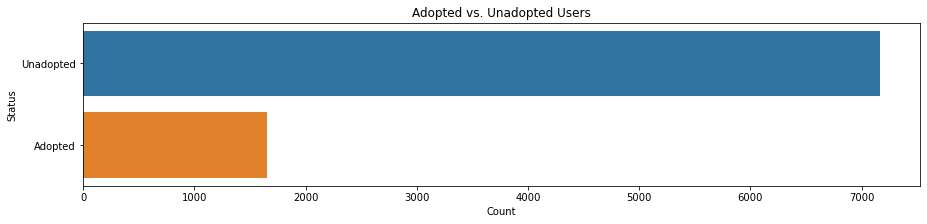

In [524]:
fig, ax = plt.subplots(figsize=(15,3))
ax = sns.countplot(y='adopted', data=main_df)
ax.set(xlabel= 'Count', ylabel= 'Status', title="Adopted vs. Unadopted Users")
ax.set_yticklabels(['Unadopted', 'Adopted' ])        
plt.show()

In [525]:
print(f' { round(len(main_df[main_df["adopted"] == 1]) / len(main_df) * 100, 2)} % of users are adopted')
print(f' { round(len(main_df[main_df["adopted"] == 0]) / len(main_df) * 100, 2)} % of users are not adopted')

 18.77 % of users are adopted
 81.23 % of users are not adopted


<AxesSubplot:>

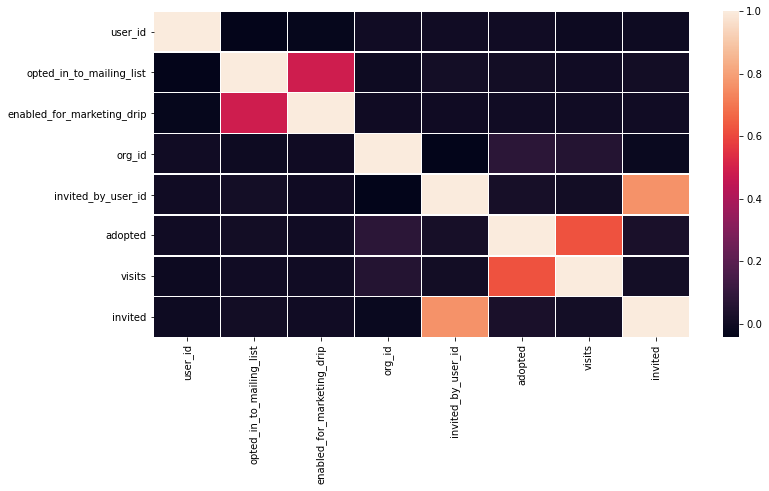

In [526]:
# explore some possible correlations 

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(main_df.corr(), linewidths=.5, ax=ax)

There's a seemingly obvious correlation between adopted status and visit count 

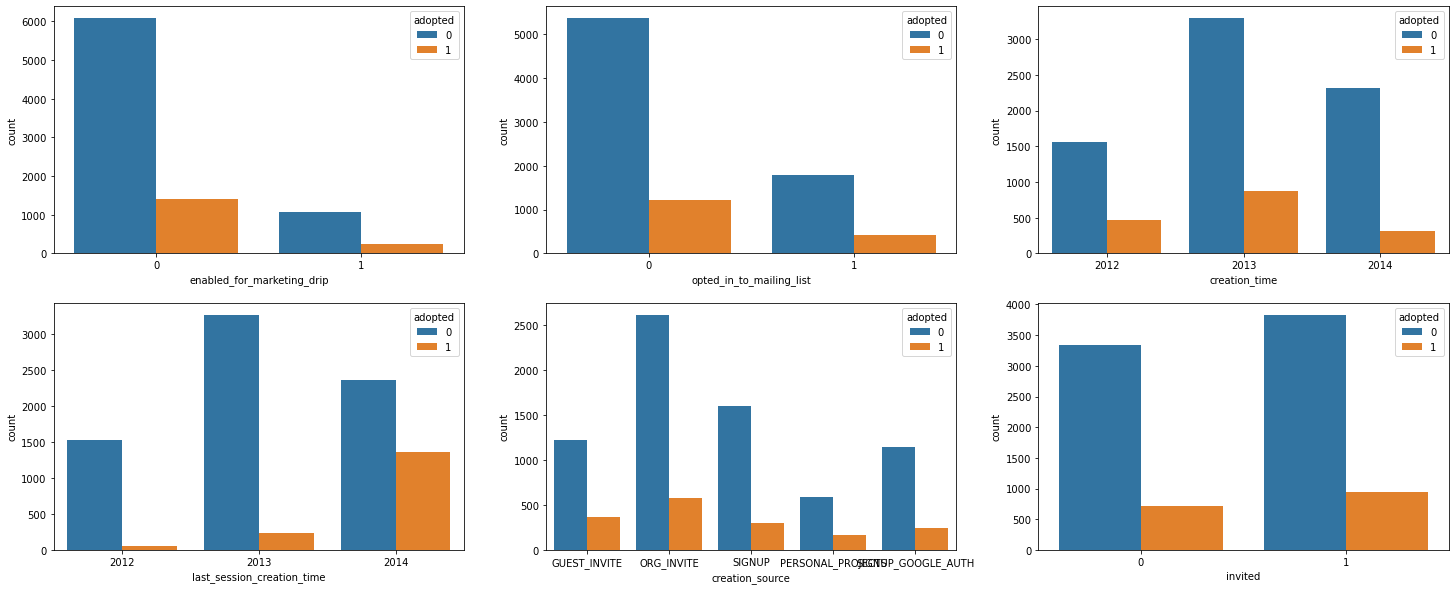

In [527]:
# plot features to compare correlations between adopted and not adopted for categorical variables 

fig, ax = plt.subplots(figsize=(25,10))

ax1 = plt.subplot(2,3,1)
ax1 = sns.countplot(x='enabled_for_marketing_drip', data=main_df, hue='adopted')

ax2 = plt.subplot(2,3,2)
ax2 = sns.countplot(x='opted_in_to_mailing_list', data=main_df, hue='adopted')

ax3 = plt.subplot(2,3,3)
ax3 = sns.countplot(x=main_df['creation_time'].dt.year, data=main_df, hue='adopted')

ax4 = plt.subplot(2,3,4)
ax4 = sns.countplot(x=main_df['last_session_creation_time'].dt.year, data=main_df, hue='adopted')

ax5 = plt.subplot(2,3,5)
ax5 = sns.countplot(x='creation_source', data=main_df, hue='adopted')

ax6 = plt.subplot(2,3,6)
ax6 = sns.countplot(x='invited', data=main_df, hue='adopted')

plt.show()

It looks like having last logged into the account in the most recent year (2014) could be a predictor of adoption. 

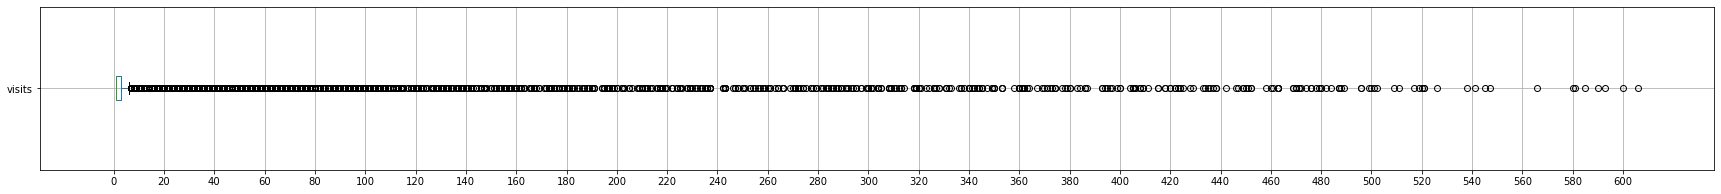

In [528]:
# show visits distribution

fig, ax = plt.subplots(figsize=(30,3))
ax = main_df.boxplot(column='visits', figsize=(30,3), vert=False)
ax.set_xticks(np.arange(0, 605, step=20))
plt.show()

There's a clear concentration of login counts that equal 1, and the density trails off as the login count gets higher. 

# Feature Engineering 

In [529]:
# dummy encode the 'creation_source' column
dummy = pd.get_dummies(main_df['creation_source'])

# add dummies back to df 
main_df = main_df.join(dummy)

# drop original 'creation source' column
main_df.drop(['creation_source'], inplace=True, axis=1)

In [530]:
# create column that represents the age of the account in days: last login date - account creation date 
main_df['account_age'] = main_df.last_session_creation_time - main_df.creation_time

# convert that column from timedelta to integer 
main_df.account_age = main_df.account_age.dt.days.astype('int')

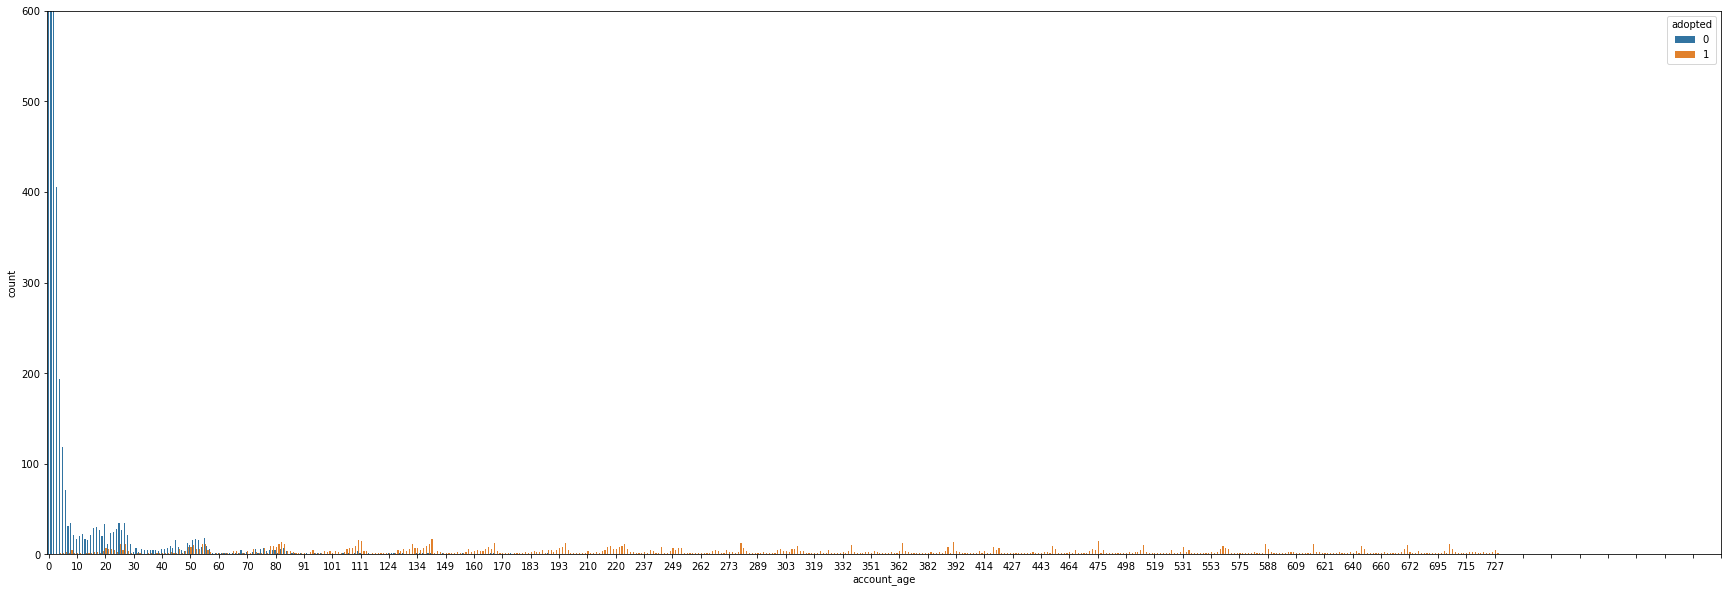

In [532]:
# view distribution of account_age colored by adopted status 

fig, ax = plt.subplots(figsize=(30,10))
ax = sns.countplot(x='account_age', data=main_df, hue='adopted')
ax.set(ylim=(0, 600))
ax.set_xticks(np.arange(0, 600, step=10))
plt.show()

We can see there'a a clear correlation between account age and adoption status. The longer the time between creation date and last login the more likely a user is to be adopted. 

In [533]:
#extract just the year from the creation time and last session time columns 

main_df.creation_time = main_df.creation_time.dt.year
main_df.last_session_creation_time = main_df.last_session_creation_time.dt.year

In [546]:
# dummy encode the 'creation_time' and the 'last_session_creation_time' columns; extract year 
dummy1 = pd.get_dummies(data = main_df['creation_time'], prefix= 'creation_year')
dummy2 = pd.get_dummies(data = main_df['last_session_creation_time'], prefix= 'last_login_year')

# add dummies back to df 
main_df = main_df.join(dummy1)
main_df = main_df.join(dummy2)


In [549]:
main_df.columns

Index(['user_id', 'creation_time', 'name', 'email',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id', 'adopted',
       'visits', 'invited', 'GUEST_INVITE', 'ORG_INVITE', 'PERSONAL_PROJECTS',
       'SIGNUP', 'SIGNUP_GOOGLE_AUTH', 'account_age', 'creation_year_2012',
       'creation_year_2013', 'creation_year_2014', 'last_login_year_2012',
       'last_login_year_2013', 'last_login_year_2014'],
      dtype='object')

In [ ]:
# main_df.org_id.value_counts()[0:20]

In [658]:
# select features for modeling dataframe

model_df = main_df[[ 'visits', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'invited', 
       'GUEST_INVITE', 'ORG_INVITE', 'PERSONAL_PROJECTS',
       'SIGNUP', 'SIGNUP_GOOGLE_AUTH', 'account_age', 'creation_year_2012',
       'creation_year_2013', 'creation_year_2014', 'last_login_year_2012',
       'last_login_year_2013', 'last_login_year_2014', 'adopted']]

# PreProcessing

In [659]:
# import preprocessing library and various tools 

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [660]:
# break off the dependent 'target' variable from the independent 'predictor' varibales 

X_independents = model_df.drop(['adopted'], axis=1)
y_target = model_df['adopted']

In [661]:
# train/test split the data 

X_train, X_test, y_train, y_test = train_test_split(X_independents, y_target, test_size=.20, random_state=22)

# Modeling with Logistic Regression

In [662]:
# import logistic regression algorithm 

from sklearn.linear_model import LogisticRegression

In [663]:
# instantiate model
lr = LogisticRegression()

# create pipeline
pipeline = Pipeline([('scaler', StandardScaler()),('lr', lr)])

In [664]:
# set up parameters to search and compare
param_grid = {"lr__C" : [0.001, 0.01, 0.1, 0.5, 1, 1.5, 3, 5, 7, 10, 50],
             "lr__penalty" : ['l2', 'none'], 
             "lr__solver" : ['saga', 'lbfgs', 'newton-cg'], 
             "lr__class_weight": [None, 'balanced']}

# create grid search - cross-validation object 
lr_gscv = GridSearchCV(pipeline, param_grid, cv=10, n_jobs=-1, scoring='accuracy')

# fit training data
lr_gscv.fit(X_train,y_train)
print("best parameters: ",lr_gscv.best_params_)


best parameters:  {'lr__C': 0.001, 'lr__class_weight': None, 'lr__penalty': 'none', 'lr__solver': 'lbfgs'}


In [665]:
# predict class for X
y_pred = lr_gscv.best_estimator_.predict(X_test)


# create function that prints evaluation scores
def evaluate(y__test, y__pred):
    ac = accuracy_score(y__test, y__pred)
    f1 = f1_score(y__test, y__pred, average='binary')
    pr = precision_score(y__test, y__pred, average='binary')
    re = recall_score(y__test, y__pred, average='binary')

    print('Accuracy Score = %.3f' % (ac))
    print('F1 Score = %.3f' % (f1))
    print("Precision = {}".format(round(pr, 3)))
    print("Recall = {}".format(round(re, 3)))


# generate accuracy and f1 scores
evaluate(y_test, y_pred)

Accuracy Score = 0.980
F1 Score = 0.947
Precision = 0.963
Recall = 0.931


In [666]:
# access and rank the coefficients for our independent variables 

pipe_steps = lr_gscv.best_estimator_.named_steps['lr']
df_coef = pd.DataFrame(zip(list(model_df.columns[:-1]),pipe_steps.coef_[0]),index=range(model_df.columns[:-1].shape[0]),columns=['feature','coefficient'])
df_coef.sort_values(by='coefficient', ascending=False)

,feature,coefficient
0,visits,126.041627
10,creation_year_2012,0.667664
14,last_login_year_2013,0.218891
15,last_login_year_2014,0.217723
6,PERSONAL_PROJECTS,0.151552
5,ORG_INVITE,0.057177
7,SIGNUP,0.022797
1,opted_in_to_mailing_list,-0.013453
3,invited,-0.051872
8,SIGNUP_GOOGLE_AUTH,-0.073087


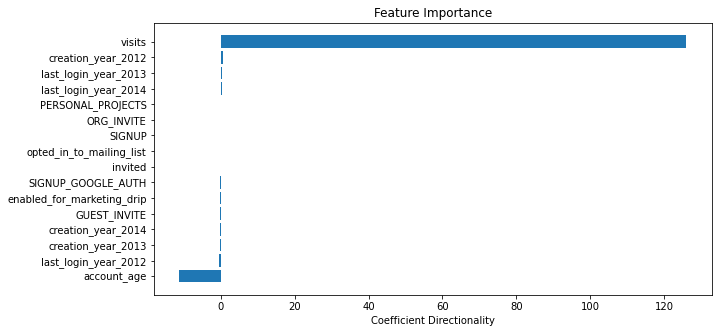

In [667]:
# plot feature importance scores(coefficients), ordered by importance

scores_ = np.array(pipe_steps.coef_[0])
sorted_idx = np.argsort(scores_)

# make plots 
pos = np.arange(sorted_idx.shape[0])
sorted_idx.size
plt.figure(figsize=(10,5))
plt.barh(pos, scores_[sorted_idx], align='center')
plt.yticks(pos, X_independents.columns[sorted_idx])
plt.xlabel('Coefficient Directionality')
plt.title('Feature Importance')
plt.show()

# Modeling with Random Forest

In [668]:
# import the Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# import permutation feature importance function 
from sklearn.inspection import permutation_importance

In [669]:
# instantiate model
rfc = RandomForestClassifier()

# create pipeline
pipeline = Pipeline([('scaler', StandardScaler()),('rfc', rfc)])


In [670]:
# Hyperparameter tuning with Random Search 

params = {'rfc__bootstrap': [True, False],
        'rfc__max_depth': [10, 15, 20, 25, 30],
        'rfc__max_features': ['auto', 'sqrt'],
        'rfc__min_samples_leaf': [1, 2, 4],
        'rfc__min_samples_split': [2, 5, 10],
        'rfc__n_estimators': [25, 50, 75, 100, 150]}


rfc_rscv = RandomizedSearchCV(pipeline, param_distributions=params, cv=5, verbose=True, random_state=13)

rfc_rscv.fit(X_train, y_train)

print(f'Best parameters: {rfc_rscv.best_params_}')
print(f'Training accuracy score from tuned model: {rfc_rscv.best_score_*100:.1f}%')
print('')

# predict class for X
y_pred = rfc_rscv.predict(X_test)

# generate accuracy scores
evaluate(y_test, y_pred)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'rfc__n_estimators': 100, 'rfc__min_samples_split': 2, 'rfc__min_samples_leaf': 4, 'rfc__max_features': 'sqrt', 'rfc__max_depth': 15, 'rfc__bootstrap': True}
Training accuracy score from tuned model: 98.2%

Accuracy Score = 0.978
F1 Score = 0.941
Precision = 0.954
Recall = 0.928


In [671]:
# create function for evaluating and plotting feature importance

def feature_metrics(model_object, pipe_model_name, title, perm=False):

    # generate permutation feature importance if desired (perm=True)
    if perm == True:
        perm_imp = permutation_importance(model_object, X_train, y_train, n_repeats=10, random_state=22)
        mean_imp = [v for k,v in perm_imp.items() if k == 'importances_mean']
        feature_importance = mean_imp[0]

    # generate GINI importance metric
    else:
        feature_importance = model_object.best_estimator_.named_steps[pipe_model_name].feature_importances_

    # create list of feature name and importance score 
    rounded_feat = [round(x,2) for x in feature_importance]
    feat_imp = list(zip(X_independents.columns[:-1],rounded_feat))

    # print list of features and their importance as a proportion of the total importance
    print('Features and their proportional importance:')
    for i in feat_imp:
        print(i[0], '=', int(i[1]*100), '%')
    
    # make plots
    sorted_idx = np.argsort(feature_importance) 
    pos = np.arange(sorted_idx.shape[0]) 
    sorted_idx.size
    plt.figure(figsize=(15,5))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X_independents.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title(title)
    plt.show()

Features and their proportional importance:
visits = 52 %
opted_in_to_mailing_list = 0 %
enabled_for_marketing_drip = 0 %
invited = 0 %
GUEST_INVITE = 0 %
ORG_INVITE = 0 %
PERSONAL_PROJECTS = 0 %
SIGNUP = 0 %
SIGNUP_GOOGLE_AUTH = 0 %
account_age = 33 %
creation_year_2012 = 1 %
creation_year_2013 = 1 %
creation_year_2014 = 4 %
last_login_year_2012 = 1 %
last_login_year_2013 = 1 %


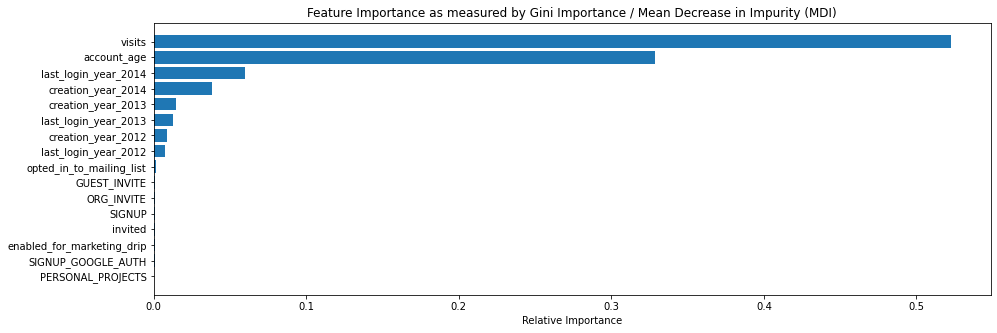

In [672]:
# GINI feature importance for Random Forest 

feature_metrics(rfc_rscv, 'rfc', 'Feature Importance as measured by Gini Importance / Mean Decrease in Impurity (MDI)')

Features and their proportional importance:
visits = 28 %
opted_in_to_mailing_list = 0 %
enabled_for_marketing_drip = 0 %
invited = 0 %
GUEST_INVITE = 0 %
ORG_INVITE = 0 %
PERSONAL_PROJECTS = 0 %
SIGNUP = 0 %
SIGNUP_GOOGLE_AUTH = 0 %
account_age = 0 %
creation_year_2012 = 0 %
creation_year_2013 = 0 %
creation_year_2014 = 0 %
last_login_year_2012 = 0 %
last_login_year_2013 = 0 %


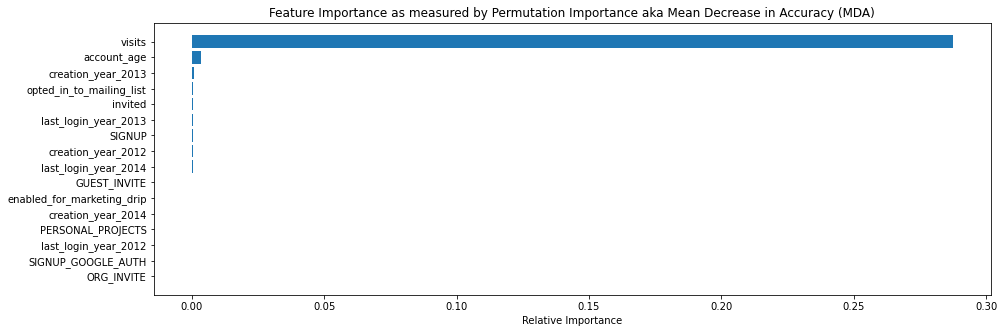

In [673]:
# Permutation feature importance for Random Forest 

feature_metrics(rfc_rscv, 'rfc', 'Feature Importance as measured by Permutation Importance aka Mean Decrease in Accuracy (MDA)', perm=True)

# Modeling with Gradient Boosting 

In [674]:
import xgboost as xgb

In [675]:
#create pipeline
boost_pipe = Pipeline([('scaler', StandardScaler()), ('xgclass', xgb.XGBClassifier())])

# pipeline with Random Search
parameters = {
     "xgclass__eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "xgclass__max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "xgclass__min_child_weight" : [ 1, 3, 5, 7 ],
     "xgclass__gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "xgclass__colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
     "xgclass__learning_rate": [0.1, 0.2, 0.3, 0.5, 0.7, 0.9]
  }

boost_rscv = RandomizedSearchCV(boost_pipe,
                    parameters, n_jobs=4,
                    scoring="accuracy",
                    cv=5)

boost_rscv.fit(X_train, y_train)

print("Best parameters:", boost_rscv.best_params_)
print("Best Score:", boost_rscv.best_score_)

# predict class for X
y_pred = boost_rscv.predict(X_test)

# generate accuracy scores
evaluate(y_test, y_pred)


Best parameters: {'xgclass__min_child_weight': 3, 'xgclass__max_depth': 4, 'xgclass__learning_rate': 0.3, 'xgclass__gamma': 0.4, 'xgclass__eta': 0.1, 'xgclass__colsample_bytree': 0.5}
Best Score: 0.9834231443353818
Accuracy Score = 0.981
F1 Score = 0.949
Precision = 0.952
Recall = 0.946


Features and their proportional importance:
visits = 18 %
opted_in_to_mailing_list = 0 %
enabled_for_marketing_drip = 0 %
invited = 0 %
GUEST_INVITE = 0 %
ORG_INVITE = 0 %
PERSONAL_PROJECTS = 0 %
SIGNUP = 0 %
SIGNUP_GOOGLE_AUTH = 0 %
account_age = 18 %
creation_year_2012 = 0 %
creation_year_2013 = 0 %
creation_year_2014 = 34 %
last_login_year_2012 = 0 %
last_login_year_2013 = 5 %


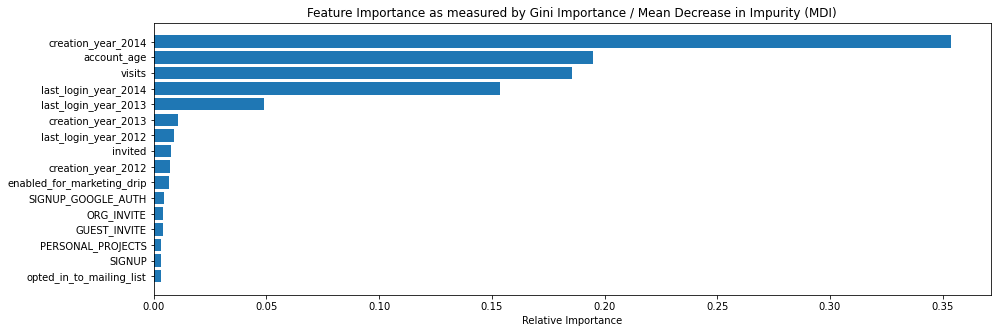

In [676]:
feature_metrics(boost_rscv, 'xgclass', 'Feature Importance as measured by Gini Importance / Mean Decrease in Impurity (MDI)')

Features and their proportional importance:
visits = 32 %
opted_in_to_mailing_list = 0 %
enabled_for_marketing_drip = 0 %
invited = 0 %
GUEST_INVITE = 0 %
ORG_INVITE = 0 %
PERSONAL_PROJECTS = 0 %
SIGNUP = 0 %
SIGNUP_GOOGLE_AUTH = 0 %
account_age = 2 %
creation_year_2012 = 0 %
creation_year_2013 = 0 %
creation_year_2014 = 0 %
last_login_year_2012 = 0 %
last_login_year_2013 = 0 %


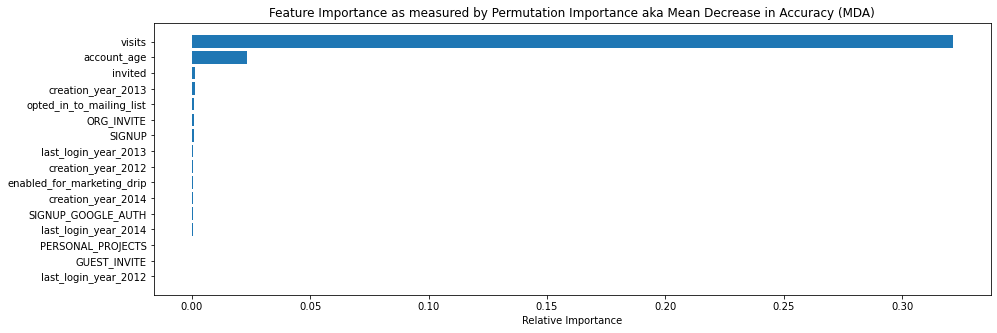

In [677]:
feature_metrics(boost_rscv, 'xgclass', 'Feature Importance as measured by Permutation Importance aka Mean Decrease in Accuracy (MDA)', perm=True)

In [678]:
# let's use the SHAP library to evaluate feature importance 

import shap

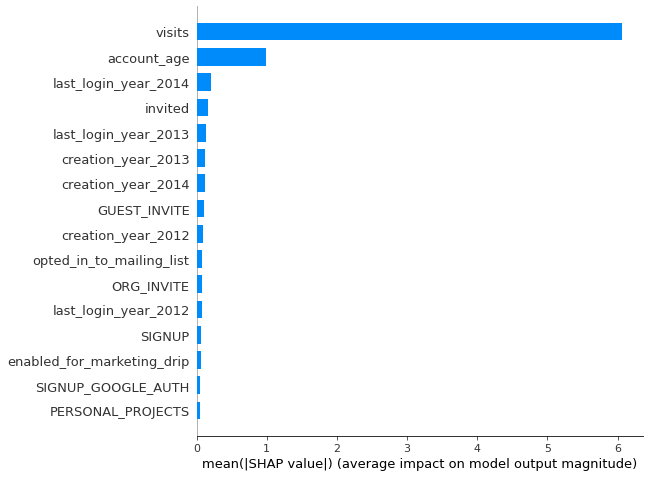

In [679]:
X_encoded = boost_rscv.best_estimator_['scaler'].fit_transform(X_train)

# fit the model 
best_model = boost_rscv.best_estimator_['xgclass'].fit(X_encoded, y_train)

# calculate the Shap values
shap_values = shap.TreeExplainer(best_model).shap_values(X_encoded)

# plot the Shap values
shap.summary_plot(shap_values, X_test, plot_type='bar')

# Write Up 

First I wrangled the data. I created an ‘adopted’ metric based on a rolling window of login time stamps. I also accumulated visit count per user. I added both of these features to the user profile data set. I decided to drop all users that weren’t present in the logins data set. My logic was that if there wasn’t any login data for these users they would be automatically classified as ‘not adopted’. If the login data was simply missing this would skew and distort the data when modeling. 

Next I engaged in some exploratory data analysis. ~19% of users were adopted and ~81% were not adopted. There were no clear correlations according to the heat map aside from visit count. There appeared to be a positive correlation between visit count and adoption status. 

I then moved to feature engineering. I created a new feature called ‘account age’ that was the difference between the last login date and the account creation date. I then plotted this against user retention and observed that the longer someone’s account had been active the more likely they were to be adopted.

Moving on to modeling, I selected the numerical features from the data frame. I was able to generate solid accuracy scores for each classification model:

Logistic Regression: 98%
Random Forest: 97.8%
Gradient Boosting: 98%

Two features stood out as the most clearly correlated: ‘visit count’ and ‘account age’. Visit count seems pretty obvious, the more someone has logged in the more likely they are to have used the product 3 times within a 7 day period. Account age is interesting and also makes sense. The longer someone has been active the more likely they’ve had a chance to be hyper-active (used the account 3 or more times within a 7 day window).

A user having logged on in the current year was also a predictor of adoption, as well as a user having been invited to the platform. The company may want to look into promoting this product for team work, being that an invitation signals collaboration and subsequent adoption. Being invited by an organization both as a guest and as a member were both predictive, implying that when organizations use our tool, adoption happens. 
